# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [1]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-d5m1134j/granite-tsfm_308e50f269214b88b5fad6e8d1352ebc
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-d5m1134j/granite-tsfm_308e50f269214b88b5fad6e8d1352ebc
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [3]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [3]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

## Zero-shot evaluation method

In [13]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning)

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

# Zeroshot

INFO:p-10455:t-8705738816:get_model.py:get_model:Loading model from: ibm-research/ttm-research-r2
INFO:p-10455:t-8705738816:get_model.py:get_model:Model loaded successfully from ibm-research/ttm-research-r2, revision = main.
INFO:p-10455:t-8705738816:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.3641158640384674, 'eval_model_preparation_time': 0.0012, 'eval_runtime': 1.6384, 'eval_samples_per_second': 1699.834, 'eval_steps_per_second': 26.856}
(2785, 96, 7)
(2785, 7, 9, 192)


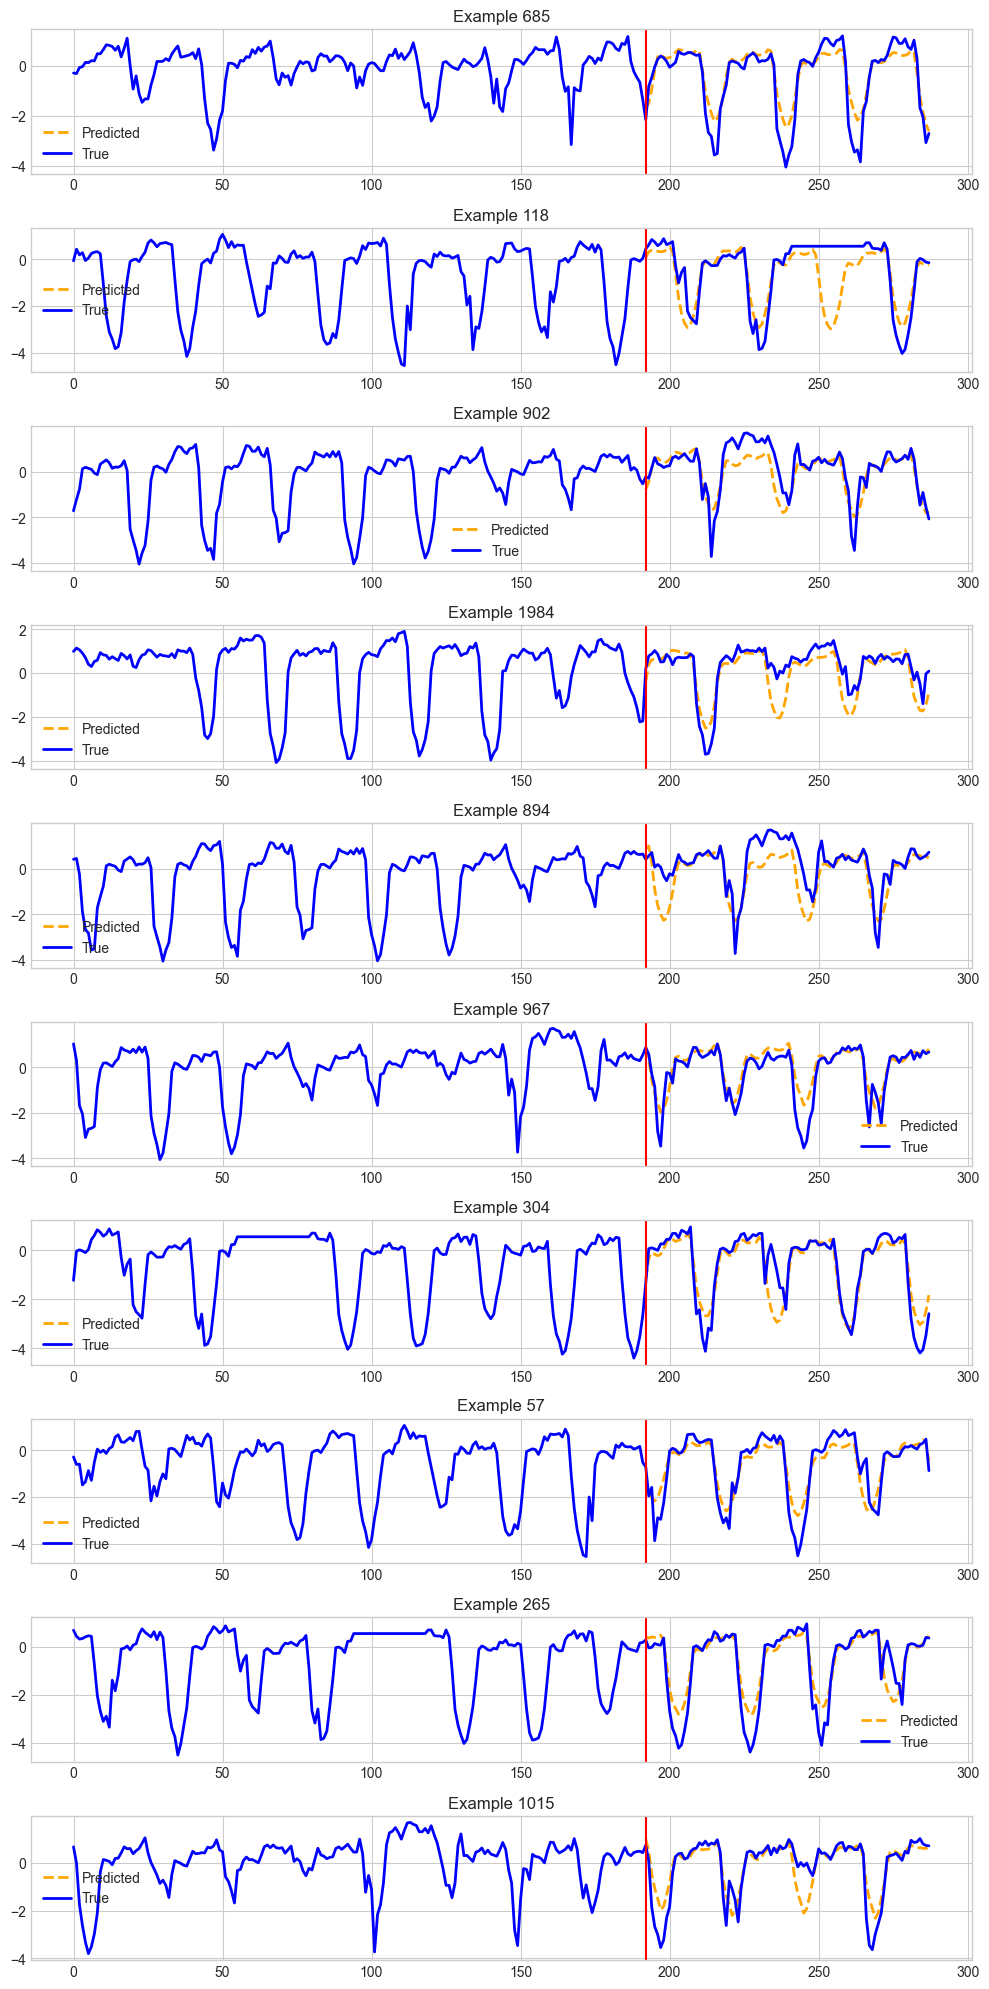

In [14]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [15]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp, data, split_config, fewshot_fraction=fewshot_percent / 100, fewshot_location="first", use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

### Few-shot 5%

In [16]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

INFO:p-10455:t-8705738816:get_model.py:get_model:Loading model from: ibm-research/ttm-research-r2


-------------------- Running few-shot 5% --------------------


INFO:p-10455:t-8705738816:get_model.py:get_model:Model loaded successfully from ibm-research/ttm-research-r2, revision = main.
INFO:p-10455:t-8705738816:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/Users/wmgifford/miniforge3/envs/granite-tsfm-del/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Number of params before freezing backbone 854972
Number of params after freezing the backbone 302162
Using learning rate = 0.001


INFO:p-11616:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11617:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11618:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11619:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11620:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11653:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11657:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11658:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.


Epoch,Training Loss,Validation Loss
1,0.787100,0.677858
2,0.719500,0.677088
3,0.686700,0.676157
4,0.680500,0.675820
5,0.650700,0.678908
6,0.639000,0.686781
7,0.625300,0.699564
8,0.601200,0.702381
9,0.583500,0.716953
10,0.558600,0.744884


INFO:p-11738:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11739:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11740:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11741:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11742:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11743:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11744:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11780:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11893:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11901:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11937:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11938:t-8705738816:config.py:<module>:PyTorch version 2.6.0 available.
INFO:p-11939:t-8705738816:config.py:<module>:PyTorch version 2.6

KeyboardInterrupt: 

# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)

INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.327900,0.273010
2,0.324500,0.272937
3,0.317400,0.272860
4,0.311000,0.272869
5,0.309400,0.273278
6,0.305200,0.274445
7,0.297900,0.276200
8,0.291600,0.279156
9,0.288500,0.283543
10,0.286300,0.286393


[TrackingCallback] Mean Epoch Time = 0.5021402285649226 seconds, Total Train Time = 16.38167715072632
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.36178672313690186, 'eval_runtime': 0.7392, 'eval_samples_per_second': 3767.434, 'eval_steps_per_second': 59.521, 'epoch': 13.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 96, 7)
(2785, 7, 8, 192)


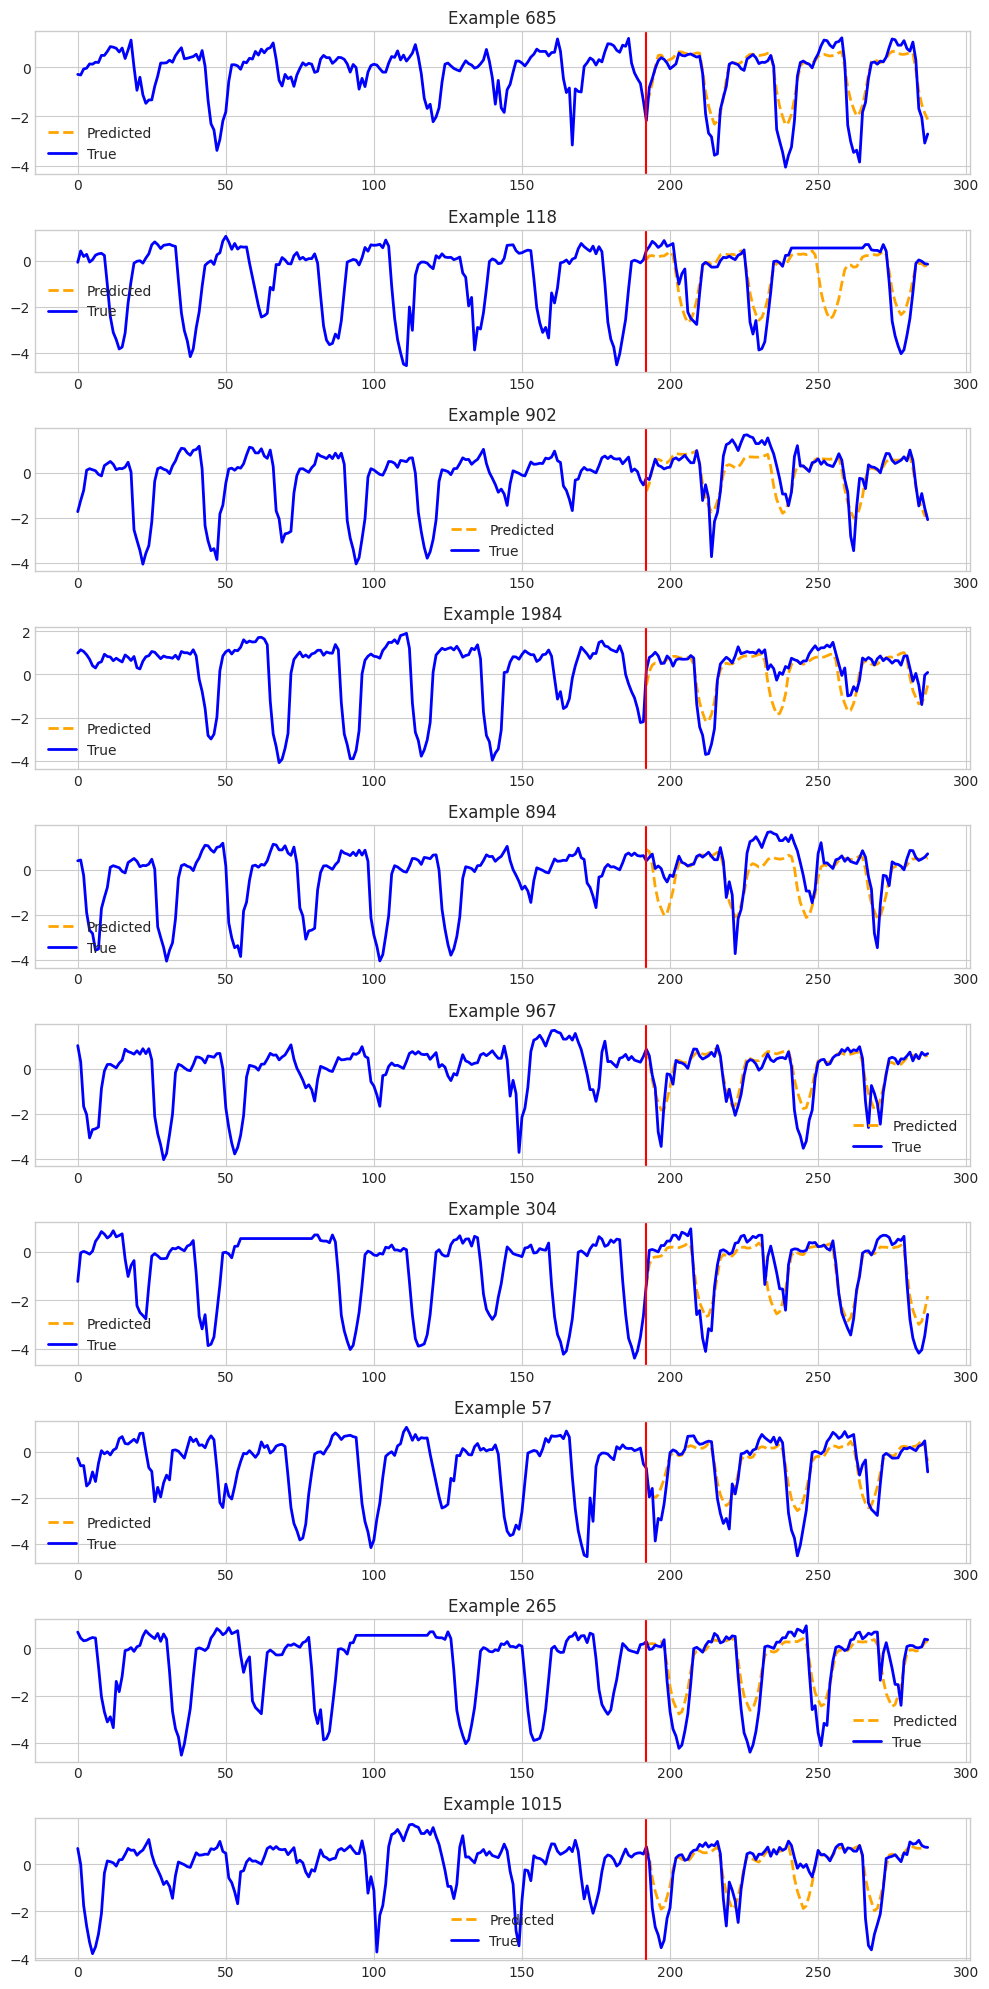

In [10]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

## Example: TTM for other forecast horizon lengths and context lengths

The minimum / maximum supported context length for the Granite-TTM-R2 models are 52 and 1536 respectively. Whereas the maximum supported prediction length for Granite-TTM-R2 is 720. (For other models, see the respective model cards) 

However, we can ask for a different context length or forecast length, and the `get_model()` utility will choose the closest possible TTM from the model suite. We have to make sure that the required context and prediction lengths are passed to the `TimeSeriesPreprocessor()` so that the data batches are generated correctly. In this notebook, this is handled in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions.

### Zero-shot

INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1024-96-r2.
INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 1024, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.33274462819099426, 'eval_model_preparation_time': 0.0021, 'eval_runtime': 1.3994, 'eval_samples_per_second': 2024.394, 'eval_steps_per_second': 32.156}
(2833, 48, 7)
(2833, 7, 8, 384)


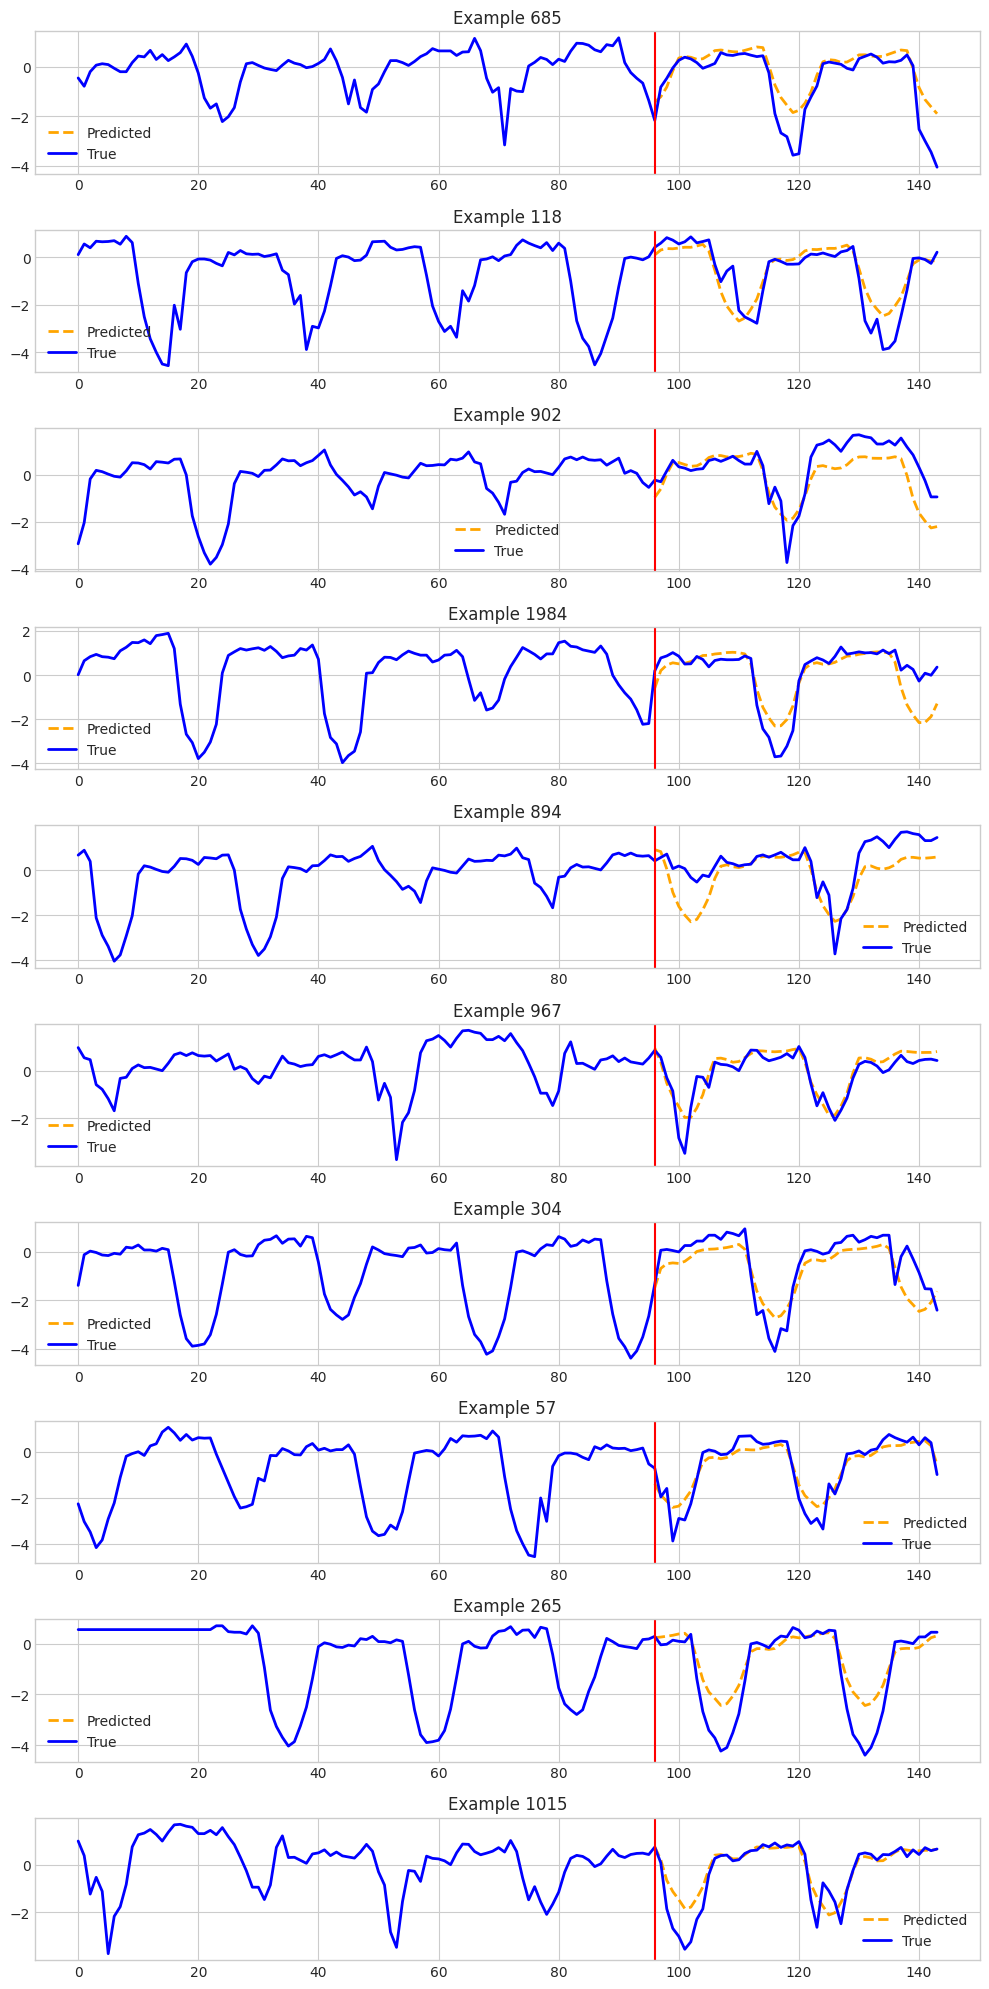

In [11]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=1024, forecast_length=48, batch_size=64)

### Few-shot 5%

INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-96-r2.
INFO:/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 1536, prediction_length = 96


Number of params before freezing backbone 3081120
Number of params after freezing the backbone 1054560


OPTIMAL SUGGESTED LEARNING RATE = 0.00035938136638046257
Using learning rate = 0.00035938136638046257


Epoch,Training Loss,Validation Loss
1,0.558300,0.504625
2,0.522800,0.505693
3,0.492200,0.506962
4,0.483700,0.508520
5,0.397600,0.510497
6,0.323300,0.514045
7,0.345200,0.525361
8,0.280800,0.541318
9,0.238600,0.550981
10,0.221500,0.592485


[TrackingCallback] Mean Epoch Time = 0.5180372975089333 seconds, Total Train Time = 16.083559274673462
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.32994186878204346, 'eval_runtime': 0.8717, 'eval_samples_per_second': 3250.02, 'eval_steps_per_second': 51.624, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2833, 48, 7)
(2833, 7, 12, 384)


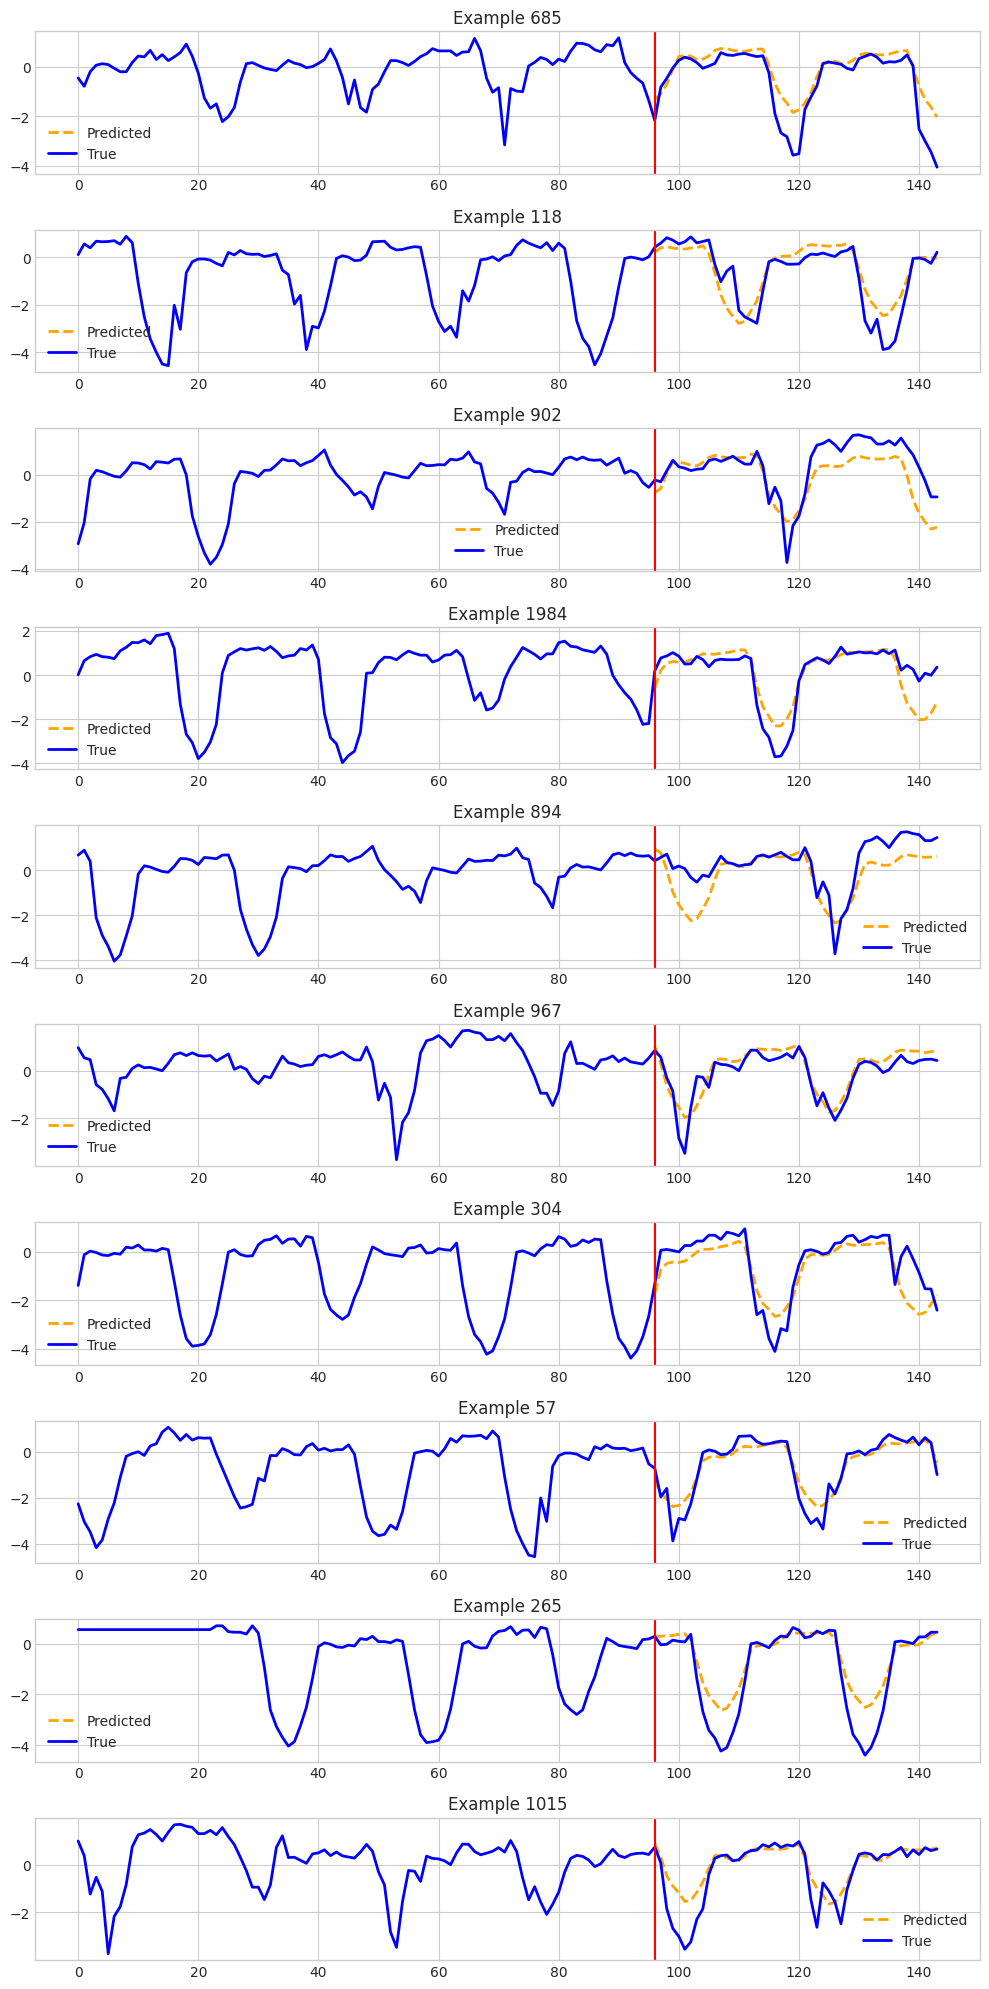

In [12]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=1536,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)